In [1]:
#from skimage import io,transform
#import glob
import numpy as np
import scipy.io
from scipy.signal import convolve2d
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Functions

## Gabor 

In [2]:
def gabor_wavelet(rows, cols, kmax, f, orientation, scale, delt2):

    k = (kmax / (f ** scale)) * np.exp(1j * orientation * np.pi / 4)
    kn2 = np.abs(k) ** 2

    gw = np.zeros((rows, cols), np.complex128)

    for m in range(int(-rows/2) + 1, int(rows / 2) + 1):
        for n in range(int(-cols/2) + 1, int(cols / 2) + 1):
            t1 = np.exp(-0.5 * kn2 * (m**2 + n**2) / delt2)
            t2 = np.exp(1j * (np.real(k) * m + np.imag(k) * n))
            t3 = np.exp(-0.5 * delt2)
            gw[int(m + rows/2 - 1),int(n + cols/2 - 1)] = (kn2 / delt2) * t1 * (t2 - t3)

    return gw

def build_filters(num_or, num_sc, rows=4, cols=4, plot=False):
    
    # num_or as number of orientations
    # num_sc as number of scales
    
    filters = []
    kmax = np.pi / 2
    f = np.sqrt(2)
    delt2 = (np.pi) ** 2
    
    for v in range(0, num_sc):
        for u in range(0, num_or):
            gw = gabor_wavelet(rows, cols, kmax, f, u, v, delt2)
            filters.append(gw)

    if plot:
        fig = plt.figure(figsize=(10,5))
        for v in range(0, num_sc):
            for u in range(0, num_or):
                fig.add_subplot(2, 4, 4*(v) + (u+1), xticks=[], yticks=[])
                plt.imshow(np.real(filters[(v*num_or)+u]), cmap='gray')
                
        plt.show()
    
    return filters

def extract_features(img, filters, plot=False):

    results = []
    
    for i in range(8):
        resultR = cv2.filter2D(img, cv2.CV_32F, np.real(filters[i]))
        resultI = cv2.filter2D(img, cv2.CV_32F, np.imag(filters[i]))
        result = np.hypot(resultR, resultI)
        results.append(result) 

    if plot:
        fig = plt.figure(figsize=(16,4))
        for i in range(8):
            fig.add_subplot(1, 8, (i+1), xticks=[], yticks=[])
            plt.imshow(np.real(results[i]), cmap='gray') 
        plt.show()
    
    return results

## LBP

In [3]:
def get_pixel(img, center, x, y):
    
    new_value = 0
    try:
        if img[x,y] >= center:
            new_value = 1       
    except:
        pass
      
    return new_value
   
def lbp_pixel(img, x, y):
   
    center = img[x,y]
    # Neighbors in a clockwise direction
    xplace = [-1,-1,-1,0,1,1,1,0]
    yplace = [-1,0,1,1,1,0,-1,-1]
    
    val = 0
    # Compute LBP codewords
    for k in range(len(xplace)):
        val += (get_pixel(img, center, x+xplace[k], y+yplace[k]))*(2**k)
          
    return val

def lbp(img, width, height, normalize=True, plot=False):
    
    LBPdesc = np.zeros((width, height),np.uint8)

    for i in range(0, width):
        for j in range(0, height):
            LBPdesc[i, j] = lbp_pixel(img, i, j)
    if plot:
        plt.imshow(LBPdesc, cmap ="gray")
        plt.xticks([])
        plt.yticks([])
        
    
    LBPdesc = np.histogram(LBPdesc.ravel(),range(256))[0]
    
    if normalize:
        LBPdesc=LBPdesc/LBPdesc.sum()
    
    return LBPdesc

## LPQ

In [4]:
def lpq(img, winSize=3, normalize=True, plot=False):

    STFTalpha=1/winSize

    convmode='same'

    img=np.float32(img)
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    #  Gaussian STFT filters
    w0=np.ones_like(x)
    w1=np.exp(-2*np.pi*x*STFTalpha*1j)
    w2=np.conj(w1)
    
    sigmaS=(winSize-1)/4
    gs=np.exp(-0.5*(x/sigmaS)**2)/(np.sqrt(2*np.pi)*sigmaS);
    
    w0=gs*w0;
    w1=gs*w1;
    w2=gs*w2;
    
    w1=w1-np.mean(w1);
    w2=w2-np.mean(w2);
    # Run filters to compute the frequency response in the four points
    filterResp1=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp2=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates
    freqResp=np.dstack([filterResp1.real, filterResp2.real, filterResp3.real, filterResp4.real,
                        filterResp1.imag, filterResp2.imag, filterResp3.imag, filterResp4.imag])
    
    # Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)
    
    if plot:
        plt.imshow(np.uint8(LPQdesc),cmap='gray')
        plt.xticks([])
        plt.yticks([])

    # Histogram
    LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    if normalize:
        LPQdesc=LPQdesc/LPQdesc.sum()

    return LPQdesc

## 1-Nearest Neighbour Classification

In [5]:
def classify(train_data, test_data, ytrain, ytest):

    classifier = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    classifier.fit(train_data, np.squeeze(ytrain))
    ypred = classifier.predict(test_data)

    confmat = confusion_matrix(ytest, ypred, range(1,16))
    print('Confusion Matrix:\n',confmat)
    acc = np.sum(np.diag(confmat))/np.sum(confmat)*100
    print('Accuracy: ',acc)
    

# Dataset

In [6]:
mat = scipy.io.loadmat('Yale_64x64.mat')

In [7]:
imglist=[]
labels = mat['gnd']
for i in range(labels.shape[0]):
    img = mat['fea'][i].reshape((64,64)).T
    imglist.append(img)
imglist = np.array(imglist)

In [8]:
xtrain, ytrain, xtest, ytest = [], [], [], []

for i in range(0,15):
    for j in range(0,6):
        xtrain.append(imglist[(i*11)+j])
        ytrain.append(labels[(i*11)+j])
    for j in range(6,11):
        xtest.append(imglist[(i*11)+j])
        ytest.append(labels[(i*11)+j])
xtrain, ytrain, xtest, ytest = np.array(xtrain),np.array(ytrain), np.array(xtest),np.array(ytest)
#print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

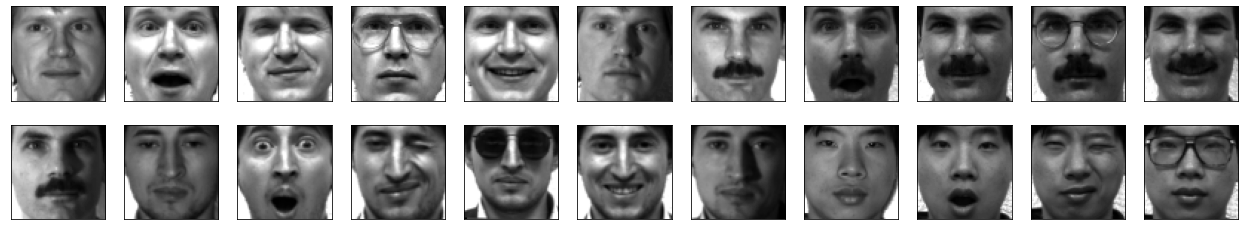

In [9]:
plt.figure(figsize=(22,4))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(xtrain[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

# Filters

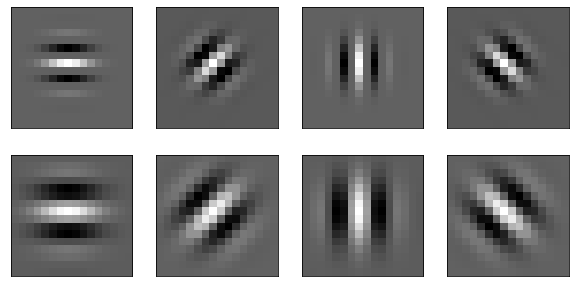

In [10]:
gabor_filters = build_filters(4,2,16,16,plot=True)

In [11]:
# Images Themselves

train_plain = []
for img in xtrain:
    train_plain.append(img.ravel())
train_plain = np.array(train_plain)
print('train pixels shape: ',train_plain.shape)

test_plain = []
for img in xtest:
    test_plain.append(img.ravel())
test_plain = np.array(test_plain)
print('test pixels shape: ',test_plain.shape)
print('\nSimply the pixels of the images themselves:\n')
classify(train_plain, test_plain, ytrain, ytest)

train pixels shape:  (90, 4096)
test pixels shape:  (75, 4096)

Simply the pixels of the images themselves:

Confusion Matrix:
 [[4 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 4 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 2 0 0 0 0 0 2 0]
 [0 1 0 0 0 0 0 0 3 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 4 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Accuracy:  77.33333333333333


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# LBP Features

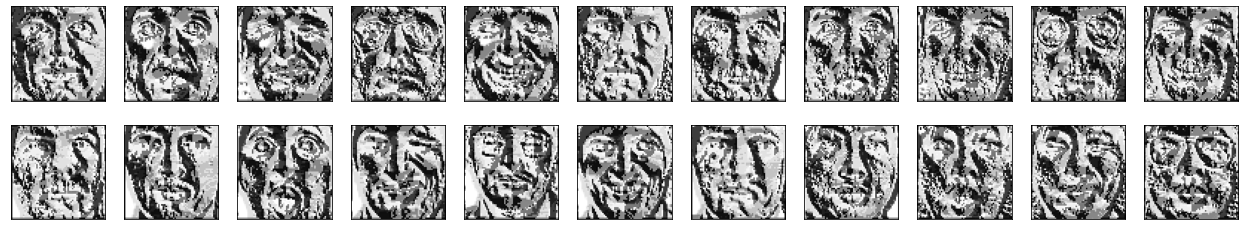

train lbp shape:  (90, 255)


In [12]:
train_lbp = []
plt.figure(figsize=(22,4))
t = True
n = 1
for img in xtrain:
    if n<=22:
        plt.subplot(2,11,n)
    train_lbp.append(lbp(img, img.shape[0], img.shape[1],plot=t))
    if n==22:
        t=False
    n+=1
plt.show()
train_lbp = np.array(train_lbp)
print('train lbp shape: ',train_lbp.shape)

In [13]:
test_lbp = []
for img in xtest:
    test_lbp.append(lbp(img, img.shape[0], img.shape[1]))
test_lbp = np.array(test_lbp)
print('test lbp shape: ',test_lbp.shape)

test lbp shape:  (75, 255)


In [14]:
print('\nLBP Features:\n')
classify(train_lbp, test_lbp, ytrain, ytest)


LBP Features:

Confusion Matrix:
 [[2 1 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 3 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [2 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 3 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 3 0 0 1 0]
 [0 2 0 1 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 4 0]
 [0 0 0 1 0 0 0 0 2 0 0 0 0 0 2]]
Accuracy:  61.33333333333333


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# LPQ Features

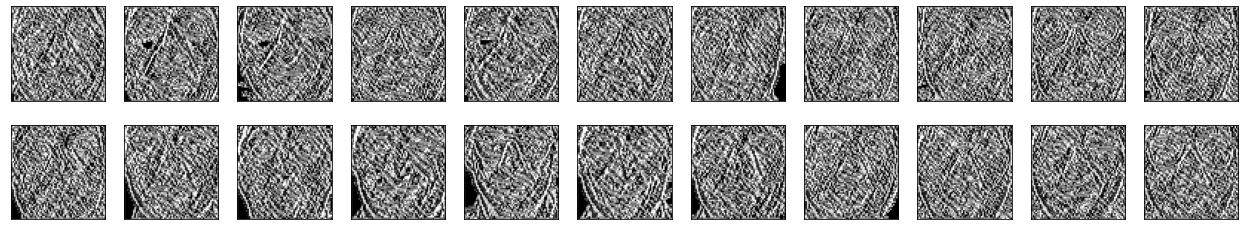

train lpq shape:  (90, 255)


In [15]:
train_lpq = []
plt.figure(figsize=(22,4))
t = True
n = 1
for img in xtrain:
    if n<=22:
        plt.subplot(2,11,n)
    train_lpq.append(lpq(img,plot=t))
    if n==22:
        t=False
    n+=1
plt.show()
train_lpq = np.array(train_lpq)
print('train lpq shape: ',train_lpq.shape)

In [16]:
test_lpq = []
for img in xtest:
    test_lpq.append(lpq(img))
test_lpq = np.array(test_lpq)
print('test lpq shape: ',test_lpq.shape)

test lpq shape:  (75, 255)


In [17]:
print('\nLPQ Features:\n')
classify(train_lpq, test_lpq, ytrain, ytest)


LPQ Features:

Confusion Matrix:
 [[2 0 0 1 1 0 0 0 1 0 0 0 0 0 0]
 [0 4 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 4 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 3 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 3 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 3 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 3]]
Accuracy:  69.33333333333334


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# Gabor+LBP Features

In [18]:
train_gabor = []
#t=True
#n=1
t=False
for img in xtrain:
    train_gabor.append(extract_features(img, gabor_filters, plot=t))
    #if n==8:
    #    t=False
    #n+=1

train gabor lbp shape:  (90, 2040)


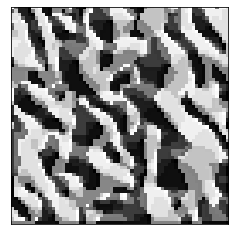

In [19]:
train_gabor_lbp = []
t=True
for i in range(len(xtrain)):
    lbpdesc = []
    for j in range(len(train_gabor[i])):
        lbpdesc.append(lbp(train_gabor[i][j], train_gabor[i][j].shape[0], train_gabor[i][j].shape[1],plot=t))
    lbp_all = np.concatenate(lbpdesc, axis=None)
    t=False
    train_gabor_lbp.append(lbp_all)
train_gabor_lbp = np.array(train_gabor_lbp)
print('train gabor lbp shape: ',train_gabor_lbp.shape)

In [20]:
test_gabor = []
for img in xtest:
    test_gabor.append(extract_features(img, gabor_filters))

In [21]:
test_gabor_lbp = []
for i in range(len(xtest)):
    lbpdesc = []
    for j in range(len(test_gabor[i])):
        lbpdesc.append(lbp(test_gabor[i][j], test_gabor[i][j].shape[0], test_gabor[i][j].shape[1]))
    lbp_all = np.concatenate(lbpdesc, axis=None)
    test_gabor_lbp.append(lbp_all)
test_gabor_lbp = np.array(test_gabor_lbp)
print('test gabor lbp shape: ',test_gabor_lbp.shape)

test gabor lbp shape:  (75, 2040)


In [22]:
print('\nGabor+LBP Features:\n')
classify(train_gabor_lbp, test_gabor_lbp, ytrain, ytest)


Gabor+LBP Features:

Confusion Matrix:
 [[3 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 3 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Accuracy:  80.0


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# Gabor+LPQ Features

train gabor lpq shape:  (90, 2040)


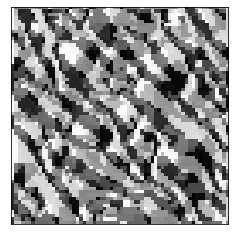

In [23]:
train_gabor_lpq = []
t=True
for i in range(len(xtrain)):
    lpqdesc = []
    for j in range(len(train_gabor[i])):
        lpqdesc.append(lpq(train_gabor[i][j],plot=t))
    lpq_all = np.concatenate(lpqdesc, axis=None)
    t=False
    train_gabor_lpq.append(lpq_all)
train_gabor_lpq = np.array(train_gabor_lpq)
print('train gabor lpq shape: ',train_gabor_lpq.shape)

In [24]:
test_gabor_lpq = []
for i in range(len(xtest)):
    lpqdesc = []
    for j in range(len(test_gabor[i])):
        lpqdesc.append(lpq(test_gabor[i][j]))
    lpq_all = np.concatenate(lpqdesc, axis=None)
    test_gabor_lpq.append(lpq_all)
test_gabor_lpq = np.array(test_gabor_lpq)
print('test gabor lpq shape: ',test_gabor_lpq.shape)

test gabor lpq shape:  (75, 2040)


In [25]:
print('\nGabor+LPQ Features:\n')
classify(train_gabor_lpq, test_gabor_lpq, ytrain, ytest)


Gabor+LPQ Features:

Confusion Matrix:
 [[4 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 4 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Accuracy:  88.0


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# Gabor+LBP+LPQ Features

In [26]:
train_gabor_lbp_lpq = np.append(train_gabor_lbp, train_lpq, axis=1)
print('train_gabor_lbp_lpq shape: ', train_gabor_lbp_lpq.shape)

train_gabor_lbp_lpq shape:  (90, 2295)


In [27]:
test_gabor_lbp_lpq = np.append(test_gabor_lbp, test_lpq, axis=1)
print('test_gabor_lbp_lpq shape: ', test_gabor_lbp_lpq.shape)

test_gabor_lbp_lpq shape:  (75, 2295)


In [28]:
print('\nGabor+LBP + LPQ Features:\n')
classify(train_gabor_lbp_lpq, test_gabor_lbp_lpq, ytrain, ytest)


Gabor+LBP + LPQ Features:

Confusion Matrix:
 [[3 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 3 0 1 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Accuracy:  80.0


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


# Gabor+LBP+Gabor+LPQ Features

In [29]:
train_gabor_lbp_gabor_lpq = np.append(train_gabor_lbp, train_gabor_lpq, axis=1)
print('train_gabor_lbp_gabor_lpq shape: ', train_gabor_lbp_gabor_lpq.shape)

train_gabor_lbp_gabor_lpq shape:  (90, 4080)


In [30]:
test_gabor_lbp_gabor_lpq = np.append(test_gabor_lbp, test_gabor_lpq, axis=1)
print('test_gabor_lbp_gabor_lpq shape: ', test_gabor_lbp_gabor_lpq.shape)

test_gabor_lbp_gabor_lpq shape:  (75, 4080)


In [31]:
print('\nGabor+LBP + Gabor+LPQ Features:\n')
classify(train_gabor_lbp_gabor_lpq, test_gabor_lbp_gabor_lpq, ytrain, ytest)


Gabor+LBP + Gabor+LPQ Features:

Confusion Matrix:
 [[3 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Accuracy:  90.66666666666666


C:\Users\HR\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=range(1, 16) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
